In [225]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

In [198]:
import os
from os.path import expanduser
home = expanduser("~")
os.chdir(os.path.join(home, 'Documents', 'Trainings', 'inpost'))
print('Current working directory set to:')
os.getcwd()

Current working directory set to:


'/Users/joannawojdylo/Documents/Trainings/inpost'

In [199]:
RAW_DIR = os.path.join(os.getcwd(), 'data', 'raw')

In [200]:
clients = pd.read_csv(os.path.join(RAW_DIR, 'klienci.csv'), index_col = 0)
session_info = pd.read_csv(os.path.join(RAW_DIR, 'session_info.csv'))
session_geo = pd.read_csv(os.path.join(RAW_DIR, 'session_geo.csv'))

### Mały feature engineering na początek, aby uzyskać dwie przydatne informacje

In [201]:
clients['srednia_dlugosc_sesji_min']=session_info.groupby("klient_id")['dlugosc_sesji_min'].mean()

In [202]:
session_info['date'] = pd.to_datetime(session_info['date'], infer_datetime_format=True, errors="coerce")
session_info_clean_date = session_info.dropna(subset=['date'])
session_info_clean_date['month'] = session_info_clean_date['date'].dt.to_period('M')
session_info_clean_date.head(10)

/var/folders/yc/q5bjbbwn1jd8gffd9tkxxp1r0000gn/T/ipykernel_33841/2114978671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_info_clean_date['month'] = session_info_clean_date['date'].dt.to_period('M')


,id_sesji,klient_id,date,dlugosc_sesji_min,month
0,972387,0,2020-05-01 18:07:54,3.302053,2020-05
1,384994,0,2020-04-14 13:31:19,0.274498,2020-04
2,173981,0,2020-08-04 17:36:17,2.846373,2020-08
3,144649,0,2020-04-14 09:54:36,1.009348,2020-04
4,475443,0,2020-04-24 21:51:14,4.217949,2020-04
5,309859,0,2020-04-26 09:56:34,4.798495,2020-04
6,441499,0,2020-04-14 14:43:53,9.465938,2020-04
7,815406,0,2020-06-11 19:29:20,3.706595,2020-06
9,215560,0,2020-04-04 18:25:34,7.643954,2020-04
10,50839,0,2020-06-17 19:13:38,4.362389,2020-06


In [203]:
clients["srednia_liczba_sesji_na_miesiac"] = session_info_clean_date.groupby(["klient_id", "month"]).count().groupby(["klient_id"])['date'].mean()

In [204]:
clients[['srednia_dlugosc_sesji_min', 'srednia_liczba_sesji_na_miesiac']] = clients[['srednia_dlugosc_sesji_min', 'srednia_liczba_sesji_na_miesiac']].round()

In [205]:
# id klientów nie będzie nam już potrzebne
clients.drop("klient_id", axis=1, inplace=True)

In [206]:
clients = pd.get_dummies(clients, columns=["wyksztalcenie"])
clients.dropna(inplace=True) # we have to remove NaN values for Random forest classifier

In [207]:
clients[clients['czy_kupil']==1]['czy_kupil'].count() 
# zauważmy, że nasze klasy nie są zbalansowane 916 kont premium vs 4254 kont nie-premium

916

In [208]:
clients.head()

,czy_samochod,czy_mieszkanie,plec,wynagrodzenie,wiek,czy_kupil,czy_w_bazie_klientow,liczba_zakupionych_wczesniej_produktow,srednia_dlugosc_sesji_min,srednia_liczba_sesji_na_miesiac,wyksztalcenie_podstawowe,wyksztalcenie_srednie,wyksztalcenie_wyzsze
0,0,1.0,0,8643.0,61.0,0,0,3.0,6.0,3.0,1,0,0
1,0,0.0,0,5537.0,44.0,0,1,11.0,14.0,4.0,0,1,0
2,1,1.0,0,8985.0,50.0,0,1,39.0,9.0,3.0,1,0,0
3,1,0.0,0,5547.0,57.0,0,1,8.0,7.0,3.0,0,1,0
4,0,0.0,1,9211.0,54.0,0,1,7.0,9.0,2.0,0,0,1


### Zacznijmy budowe klasyfikatora

In [209]:
y=clients['czy_kupil'].values
y.shape

(5170,)

In [210]:
X = clients.drop("czy_kupil", axis=1).values
X.shape

(5170, 12)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [212]:
clf = RandomForestClassifier(n_estimators = 100) 

In [213]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [214]:
y_pred = clf.predict(X_test)

In [215]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
# sprawdzamy accuracy, ale pamiętamy, że może zakłamywać wyniki bo klasy są nierówne

ACCURACY OF THE MODEL:  0.8420373952288845


/Users/joannawojdylo/opt/anaconda3/envs/inpost/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


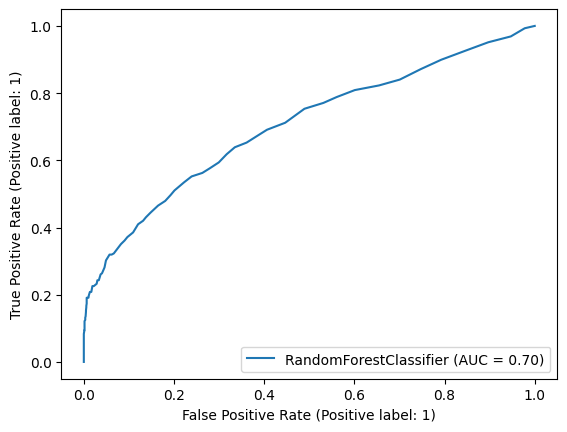

In [216]:
metrics.plot_roc_curve(clf, X_test, y_test)
# dlatego zobaczmy też na krzywą ROC i wyliczone AUC ROC

In [217]:
metrics.f1_score(y_test, y_pred, average=None)

array([0.91068174, 0.31754875])

Sprawdźmy, które cechy okazały się najważniejsze w naszym modelu:

In [218]:
feature_imp = pd.Series(clf.feature_importances_, index = clients.drop("czy_kupil", axis=1).columns).sort_values(ascending = False)
feature_imp

wynagrodzenie                             0.245527
wiek                                      0.229460
srednia_dlugosc_sesji_min                 0.143163
liczba_zakupionych_wczesniej_produktow    0.137725
plec                                      0.057694
srednia_liczba_sesji_na_miesiac           0.057669
czy_samochod                              0.028504
czy_w_bazie_klientow                      0.024787
czy_mieszkanie                            0.023037
wyksztalcenie_srednie                     0.017991
wyksztalcenie_wyzsze                      0.017641
wyksztalcenie_podstawowe                  0.016803
dtype: float64

Usuńmy mało istotne cechy, z wynikiem poniżej 0.05 i zobaczmy czy uda nam się nieco ulepszyć model

In [219]:
X_new = clients.drop(["czy_kupil", "czy_samochod", "czy_mieszkanie", "czy_w_bazie_klientow", "wyksztalcenie_srednie", "wyksztalcenie_wyzsze", "wyksztalcenie_podstawowe"], axis=1).values
X_new.shape

(5170, 6)

In [220]:
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size = 0.30)

In [221]:
clf_new = RandomForestClassifier(n_estimators = 100) 
clf_new.fit(X_train_new, y_train)
y_pred_new = clf_new.predict(X_test_new)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_new))

ACCURACY OF THE MODEL:  0.8355899419729207


Mamy nieznaczną poprawę accuracy, zobaczmy jeszcze jak wygląda krzywa ROC modelu:

/Users/joannawojdylo/opt/anaconda3/envs/inpost/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


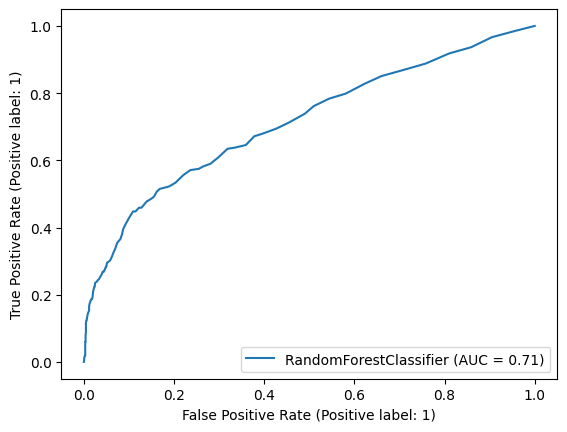

In [222]:
metrics.plot_roc_curve(clf_new, X_test_new, y_test)

In [223]:
metrics.f1_score(y_test, y_pred_new, average=None)

array([0.90538033, 0.37346437])